# 1. Abstract

<!-- Discuss business problem and who would be interested in the project -->
### 1a. Introduction  
New Jersey is a US state with a population of roughly 9 million as of 2018 [1].  Nearly 22% of that population is under the age of 18 [1].  That being said, the quality of schools is extremely important in educating our future workforce and preparing them for what comes after high school.  

### 1b. Problem  
When researching schools and places to raise a family, there are various online resources that will provide school scores and one can assume the factors that go into establishing these scores (ie. taxes, crime, etc.). However, it is not always clear what other factors might lead to these numbers, for example what sort of venues are in the vicinity of these schools, and do they have an impact on a school's score.  

### 1c. Goal  
The goal of this analysis is to shine a light on the state of New Jersey, and attempt to find any patterns at the county and district level that might exist to explain what factors could impact whether a school is high rated versus low rated.  An analysis of this type could help home buyers in choosing the right home to raise their kids in.  

# 2. Data

<!-- Describe the data and the source -->
### 2a. School Scores  
I will be using a series of APIs and CSV files for this analysis.  The NJ Schools Scores from 2017-2018 will come from the NJ Department of Education [2].  This dataset is well organized with various features including, county, district, score, percentile, amoung many others.  

### 2b. Coordinates  
We will need to make API calls to extract information for coordinates.  The ArcGIS [3] source will be used to request county and district coordinates using the geocoder Python library.  

### 2c. Venues  
We will need to make API calls to extract information for venues.  The Foursquare [4] source will be used to request venues based on coordinates and radius.

### 2d. Data Cleansing/Transforming   
After the data is extracted, we will perform transform operations to do the following:
   1. Choose the columns we want to work with
   2. Change names of columns as needed
   3. Drop columns as needed
   3. Set indexes
   
Once the calls are made to the API sources we will convert them to Pandas dataframes and save them to CSV files. 


#### Import Libraries

In [4]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# API calls
import requests # library to handle requests
from pandas.io.json import json_normalize 

import json # library to handle JSON files

# !pip install geocoder
import geocoder # import geocoder to request coordinates based on county or district

# !conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

# Visualization
import matplotlib.pyplot as plt
import matplotlib.cm as cm # color map
import matplotlib.colors as colors # colors
import seaborn as sns 

# !conda install -c conda-forge folium=0.10.1 --yes
import folium # map rendering library

# Machine Learning
from sklearn.cluster import KMeans

# Loading files from IBM Cloud
import base64
from IPython.display import HTML


print('Libraries imported.')

Libraries imported.


#### Set `run_api` to True if you want the API calls to run  
Due to the time and limit contraints from Foursquare I decided to save the data from api calls to a csv file to avoid having to run the api calls everytime.

In [175]:
run_api = False

#### Create a function to return a timestamp for our API csv files  
The `dt_stamp` function will provide a unique file name for api calls

In [6]:
# print(pd.datetime.now())
# print(pd.datetime.now().date())
def dt_stamp():
    curr_year = pd.datetime.now().year
    curr_month = pd.datetime.now().month
    curr_day = pd.datetime.now().day
    curr_hour = pd.datetime.now().hour
    curr_min = pd.datetime.now().minute
    # curr_sec = pd.datetime.now().second
    # curr_micsec = pd.datetime.now().microsecond
    stamp = '{}{}{}{}{}'.format(curr_year, curr_month, curr_day, curr_hour, curr_min)
    return stamp

print('The current date and time is: {}'.format(dt_stamp()))

The current date and time is: 20202212028


#### Extract  School Data

In [7]:
school_data = pd.read_csv('https://s3.amazonaws.com/nj-data/Education/school_scores/2017-2018/data/school_scores_2017_18.csv')
school_data.head()

,COUNTY_CODE,COUNTY_NAME,DISTRICT_CODE,DISTRICT_NAME,SCHOOL_CODE,SCHOOL_NAME,GRADESPAN,PRINCIPAL_NAME,ADDRESS,CITY_STATE_ZIP,PHONE,EMAIL,WEBSITE,FACEBOOK,TWITTER,CountyCode_x,CountyName_x,DistrictCode_x,DistrictName_x,SchoolCode_x,SchoolName_x,StudentGroup,SummativeScore_x,CutOffScoreTargetedSupImp,Targeted_LowPerf,ELAProf_MetTarget,MathProf_MetTarget,Grad4YR_MetTarget,Grad5YR_MetTarget,ELAGrowth_MetStandard,MathGrowth_MetStandard,ELP_MetTarget,CA_MetAverage,Targeted_ConsUnderPerf,CountyCode_y,CountyName_y,DistrictCode_y,DistrictName_y,SchoolCode_y,SchoolName_y,SummativeRating,SummativeScore
0,1,ATLANTIC,10,ABSECON CITY,50,EMMA C ATTALES,05-08,MR. BURNS,800 IRELAN AVENUE,ABSECON NJ 08201,(609)641-5375,KBURNS@ABSECONSCHOOLS.ORG,https://www.abseconschools.org/Domain/9,NaN,NaN,1,ATLANTIC,10,ABSECON CITY,50,EMMA C ATTALES,Schoolwide,NaN,N,No,Met Target†,Not Met,N,N,Met Standard,Met Standard,**,Met,No,1,ATLANTIC,10,ABSECON CITY,50,EMMA C ATTALES,38.98,43.95
1,1,ATLANTIC,10,ABSECON CITY,60,H ASHTON MARSH,PK-04,MR. GIARDINA,800 IRELAN AVE,ABSECON NJ 08201,(609)641-5375,JGIARDINA@ABSECONSCHOOLS.ORG,https://www.abseconschools.org/Domain/8,NaN,NaN,1,ATLANTIC,10,ABSECON CITY,60,H ASHTON MARSH,Schoolwide,NaN,N,No,Met Target,Met Target,N,N,Met Standard,Exceeds Standard,Met Target†,Met,No,1,ATLANTIC,10,ABSECON CITY,60,H ASHTON MARSH,57.88,55.49
2,1,ATLANTIC,110,ATLANTIC CITY,10,ATLANTIC CITY HIGH SCHOOL,09-12,MS. GIL,1400 N ALBANY AVENUE,ATLANTIC CITY NJ 08401-6153,(609)343-7300,LGIL@ACBOE.ORG,https://www.acboe.org/achs,NaN,NaN,1,ATLANTIC,110,ATLANTIC CITY,10,ATLANTIC CITY HIGH SCHOOL,Schoolwide,NaN,N,Yes,Not Met,Not Met,Met Target,Met Target,**,**,Not Met,Not Met,No,1,ATLANTIC,110,ATLANTIC CITY,10,ATLANTIC CITY HIGH SCHOOL,6.30,12.33
3,1,ATLANTIC,110,ATLANTIC CITY,30,SOVEREIGN AVENUE SCHOOL,PK-08,MS. PEYTON,3205 ARCTIC AVENUE,ATLANTIC CITY NJ 08401-3711,(609)343-7260,MPEYTON@ACBOE.ORG,https://www.acboe.org/sov,NaN,NaN,1,ATLANTIC,110,ATLANTIC CITY,30,SOVEREIGN AVENUE SCHOOL,Schoolwide,NaN,N,No,Met Target,Not Met,N,N,Met Standard,Met Standard,Met Target,Met,No,1,ATLANTIC,110,ATLANTIC CITY,30,SOVEREIGN AVENUE SCHOOL,44.91,47.31
4,1,ATLANTIC,110,ATLANTIC CITY,50,CHELSEA HEIGHTS SCHOOL,PK-08,MR. FLOOD,4101 FILBERT AVENUE,ATLANTIC CITY NJ 08401-1023,(609)343-7272,KFLOOD@ACBOE.ORG,https://www.acboe.org/ch,NaN,NaN,1,ATLANTIC,110,ATLANTIC CITY,50,CHELSEA HEIGHTS SCHOOL,Schoolwide,NaN,N,No,Not Met,Not Met,N,N,Met Standard,Met Standard,Met Target†,Not Met,No,1,ATLANTIC,110,ATLANTIC CITY,50,CHELSEA HEIGHTS SCHOOL,26.60,35.53


#### Transform School Data
With the full school score dataset loaded into a dataframe we can select only the columns we want to work with.

In [8]:
# Choose the columns we want to start with
school_df = school_data[['COUNTY_NAME', 'DISTRICT_NAME', 'SCHOOL_NAME', 'ADDRESS','GRADESPAN', 'SummativeScore', 'SummativeRating']]
school_df.head()

,COUNTY_NAME,DISTRICT_NAME,SCHOOL_NAME,ADDRESS,GRADESPAN,SummativeScore,SummativeRating
0,ATLANTIC,ABSECON CITY,EMMA C ATTALES,800 IRELAN AVENUE,05-08,43.95,38.98
1,ATLANTIC,ABSECON CITY,H ASHTON MARSH,800 IRELAN AVE,PK-04,55.49,57.88
2,ATLANTIC,ATLANTIC CITY,ATLANTIC CITY HIGH SCHOOL,1400 N ALBANY AVENUE,09-12,12.33,6.30
3,ATLANTIC,ATLANTIC CITY,SOVEREIGN AVENUE SCHOOL,3205 ARCTIC AVENUE,PK-08,47.31,44.91
4,ATLANTIC,ATLANTIC CITY,CHELSEA HEIGHTS SCHOOL,4101 FILBERT AVENUE,PK-08,35.53,26.60


In [9]:
# Rename the columns
school_df.rename(columns={'COUNTY_NAME':'County', 'DISTRICT_NAME':'District', 'SCHOOL_NAME':'School', 'ADDRESS':'Address', 'GRADESPAN':'Grade', 'SummativeScore':'Score', 'SummativeRating':'Percentile'}, inplace=True)

/Users/ankit/anaconda3/envs/PythonData/lib/python3.7/site-packages/pandas/core/frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


In [10]:
# Display dataframe
school_df.head()

,County,District,School,Address,Grade,Score,Percentile
0,ATLANTIC,ABSECON CITY,EMMA C ATTALES,800 IRELAN AVENUE,05-08,43.95,38.98
1,ATLANTIC,ABSECON CITY,H ASHTON MARSH,800 IRELAN AVE,PK-04,55.49,57.88
2,ATLANTIC,ATLANTIC CITY,ATLANTIC CITY HIGH SCHOOL,1400 N ALBANY AVENUE,09-12,12.33,6.30
3,ATLANTIC,ATLANTIC CITY,SOVEREIGN AVENUE SCHOOL,3205 ARCTIC AVENUE,PK-08,47.31,44.91
4,ATLANTIC,ATLANTIC CITY,CHELSEA HEIGHTS SCHOOL,4101 FILBERT AVENUE,PK-08,35.53,26.60


In [11]:
school_df = school_df.drop(columns=['School', 'Address', 'Grade'])

#### Charter Schools
Charter Schools seem to be throwing off the analysis with their names being used as districts and not belonging to any specific county.  For the sake of the analysis lets remove them.

In [12]:
school_df.loc[(school_df['County'] == "CHARTERS")]

,County,District,Score,Percentile
2012,CHARTERS,ACADEMY CHARTER HIGH SCHOOL,42.76,38.40
2013,CHARTERS,BERGEN ARTS AND SCIENCES CHARTER SCHOOL,63.81,75.00
2014,CHARTERS,FOUNDATION ACADEMY CS,69.66,87.50
2015,CHARTERS,CENTRAL JERSEY COLLEGE PREP CHARTER SCHOOL,91.49,97.92
2016,CHARTERS,PRIDE ACADEMY CHARTER SCHOOL,73.06,83.47
2017,CHARTERS,COMMUNITY CHARTER SCHOOL OF PATERSO,39.35,31.93
2018,CHARTERS,BURCH CHARTER SCHOOL OF EXCELLENCE,41.93,35.01
2019,CHARTERS,PAUL ROBESON HUMANITIES CHARTER SCHOOL,58.08,62.68
2020,CHARTERS,VINELAND PUBLIC CHARTER SCHOOL,38.85,31.46
2021,CHARTERS,NEWARK EDUCATORS COMMUNITY CHARTER SCHOOL,19.03,7.46


In [13]:
# Set the index to County and find Charters
school_df.set_index('County',inplace=True)
school_df.drop(index=['CHARTERS'],inplace=True)

#### Lets get the average school score for each district

In [14]:
dist_grp = school_df.groupby(['District', 'County']).mean().sort_values(by=['Score'],ascending=False).reset_index()
dist_grp.head(20)

,District,County,Score,Percentile
0,FAIR HAVEN BORO,MONMOUTH,96.730,99.880
1,ENGLEWOOD CLIFFS BORO,BERGEN,95.790,99.640
2,MENDHAM TWP,MORRIS,95.575,99.525
3,UNION COUNTY VOCATIONAL,UNION,95.086,98.510
4,ESSEX FELLS BORO,ESSEX,93.910,98.990
5,BERGEN COUNTY VOCATIONAL,BERGEN,93.090,96.845
6,MORRIS COUNTY VOCATIONAL,MORRIS,92.500,96.275
7,OCEAN COUNTY VOCATIONAL,OCEAN,92.100,96.275
8,MONMOUTH CO VOCATIONAL,MONMOUTH,91.808,96.044
9,ALLENDALE BORO,BERGEN,89.520,97.630


#### Extract Coordinates Data

#### Create a geocoder instance and test

In [15]:
g = geocoder.arcgis('OCEAN COUNTY VOCATIONAL, nj')
g.json

{'address': 'Ocean County, New Jersey',
 'bbox': {'northeast': [40.20827433500008, -73.99796530399996],
  'southwest': [39.61027433500008, -74.59596530399998]},
 'confidence': 1,
 'lat': 39.90927433500008,
 'lng': -74.29696530399997,
 'ok': True,
 'quality': 'Locality',
 'raw': {'name': 'Ocean County, New Jersey',
  'extent': {'xmin': -74.59596530399998,
   'ymin': 39.61027433500008,
   'xmax': -73.99796530399996,
   'ymax': 40.20827433500008},
  'feature': {'geometry': {'x': -74.29696530399997, 'y': 39.90927433500008},
   'attributes': {'Score': 82.61, 'Addr_Type': 'Locality'}}},
 'score': 82.61,
 'status': 'OK'}

#### Now lets create a numpy array of the districts

In [16]:
# create a numpy array of districts in order to iterate over
address_arr = dist_grp['District'].to_numpy()
address_arr

array(['FAIR HAVEN BORO', 'ENGLEWOOD CLIFFS BORO', 'MENDHAM TWP',
       'UNION COUNTY VOCATIONAL', 'ESSEX FELLS BORO',
       'BERGEN COUNTY VOCATIONAL', 'MORRIS COUNTY VOCATIONAL',
       'OCEAN COUNTY VOCATIONAL', 'MONMOUTH CO VOCATIONAL',
       'ALLENDALE BORO', 'MOUNTAINSIDE BORO', 'RIVER EDGE BORO',
       'ORADELL BORO', 'RUMSON BORO', 'CRANBURY TWP',
       'GLOUCESTER CO VOCATIONAL', 'PASSAIC COUNTY VOCATIONAL',
       'FREDON TWP', 'BRIELLE BORO', 'CLOSTER BORO', 'LITTLE SILVER BORO',
       'BAY HEAD BORO', 'MANSFIELD TWP', 'MAYWOOD BORO',
       'NORTHERN VALLEY REGIONAL', 'ISLAND HEIGHTS BORO',
       'LITTLE FALLS TWP', 'WEST MORRIS REGIONAL', 'CRESSKILL BORO',
       'TENAFLY BORO', 'FLORHAM PARK BORO', 'HARRISON TWP',
       'MENDHAM BORO', 'SANDYSTON-WALPACK TWP', 'NORTHERN HIGHLANDS REG',
       'HAWORTH BORO', 'SPRING LAKE BORO', 'UPPER SADDLE RIVER BORO',
       'SPRING LAKE HEIGHTS BORO', 'TEWKSBURY TWP',
       'RUMSON-FAIR HAVEN REG', 'ALPINE BORO', 'NEW PROVIDE

In [17]:
county_grp = school_df.groupby(['County']).mean().sort_values(by=['Score'],ascending=False).reset_index()
county_grp.head(50)

,County,Score,Percentile
0,MORRIS,66.506562,71.873125
1,BERGEN,64.979351,69.272944
2,SOMERSET,58.927639,61.591667
3,HUNTERDON,58.434500,61.649250
4,MONMOUTH,54.921351,56.048311
5,UNION,53.451181,53.330486
6,MIDDLESEX,50.829872,50.365769
7,WARREN,50.620303,50.422424
8,SUSSEX,48.162162,46.302162
9,MERCER,47.011842,45.803947


#### Lets also create an array for counties

In [18]:
county_arr = county_grp['County'].to_numpy()
county_arr

array(['MORRIS', 'BERGEN', 'SOMERSET', 'HUNTERDON', 'MONMOUTH', 'UNION',
       'MIDDLESEX', 'WARREN', 'SUSSEX', 'MERCER', 'BURLINGTON',
       'GLOUCESTER', 'HUDSON', 'ESSEX', 'PASSAIC', 'OCEAN', 'CAMDEN',
       'SALEM', 'CAPE MAY', 'ATLANTIC', 'CUMBERLAND'], dtype=object)

#### Extract Coordinates Data
We will perform API calls to extract latitude and longitudes for the district arrays we created earlier.  Since we are saving these API calls to csv files to load later, this code can be commented in order to prevent the API calls being made.

In [19]:
if run_api:
    print('Performing API calls to geocoder ArcGIS ', end='')
    coordinates = []
    counter = 0
    for address in address_arr:
      lat_lng_coords = None

    # loop until you get the coordinates
      while(lat_lng_coords is None):
        g = geocoder.arcgis('{}, New Jersey'.format(address))
        lat_lng_coords = g.latlng

      latitude = lat_lng_coords[0]
      longitude = lat_lng_coords[1]
      latlng = (address, latitude, longitude)
      coordinates.append(latlng)
      counter += 1
      print('=', end='')
    #   print(address,latitude,longitude)

    print('> Completed.')
    print('\n')
    print('-------------------------------------------')
    print("Process Completed with {} calls to geocoder".format(counter))
    print('-------------------------------------------')
    
    # Convert coordinates to data, save df to csv file
    coord_df = pd.DataFrame(data=coordinates, columns=['District', 'Latitude', 'Longitude'])
    filename = 'nj_district_coord_{}.csv'.format(dt_stamp())
    coord_df.to_csv(filename)
    print('Saved filename: {}'.format(filename))

    # read the csv file
    coordinates_df = pd.read_csv(filename)
    coordinates_df.drop(columns=['Unnamed: 0'], inplace=True)
    print('DISTRICT coordinates file has been read.')
    
else:
    print('run_api is set to False, use CSV file.')

Performing API calls to geocoder ArcGIS ================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================> Completed.


-------------------------------------------
Process Completed with 560 calls to geocoder
-------------------------------------------
Saved filename: nj_district_coord_20202212033.csv
DISTRICT coordinates file has been read.


In [20]:
# print(coordinates[:20])

In [21]:
# coord_df = pd.DataFrame(data=coordinates, columns=['District', 'Latitude', 'Longitude'])
# coord_df.head()

Create a function to save the dataframe to a csv file locally

In [22]:
# def save_file( df, title = "Download CSV file", filename = "data.csv"):  
#     csv = df.to_csv()
#     b64 = base64.b64encode(csv.encode())
#     payload = b64.decode()
#     html = '<a download="{filename}" href="data:text/csv;base64,{payload}" target="_blank">{title}</a>'
#     html = html.format(payload=payload,title=title,filename=filename)
#     return HTML(html)

In [23]:
# save_file(coord_df)

The code below will allow us to load a local csv file into our watson notebook.

In [24]:
# import types
# import pandas as pd
# from botocore.client import Config
# import ibm_boto3

# def __iter__(self): return 0

# # @hidden_cell
# # The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# # You might want to remove those credentials before you share the notebook.
# client_626192e086454bb8a9ef53501d15240f = ibm_boto3.client(service_name='s3',
#     ibm_api_key_id='vObb_3XzrVUvBUhwBK9RlDufdub3BnU5_I04sZv27r31',
#     ibm_auth_endpoint="https://iam.ng.bluemix.net/oidc/token",
#     config=Config(signature_version='oauth'),
#     endpoint_url='https://s3-api.us-geo.objectstorage.service.networklayer.com')

# body = client_626192e086454bb8a9ef53501d15240f.get_object(Bucket='datasciencecapstone-donotdelete-pr-lhdmv7necvi5fc',Key='njschoolcoordinates.csv')['Body']
# # add missing __iter__ method, so pandas accepts body as file-like object
# if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

# coordinates_df = pd.read_csv(body)
# coordinates_df.head()


In [25]:
if run_api:
    print('Coordinates df displayed below')
else:
    coordinates_df = pd.read_csv('nj_district_coord_20202212033.csv')
    coordinates_df.drop(columns=['Unnamed: 0'], inplace=True)

Coordinates df displayed below


In [26]:
coordinates_df.head()

,District,Latitude,Longitude
0,FAIR HAVEN BORO,40.36427,-74.03589
1,ENGLEWOOD CLIFFS BORO,40.87924,-73.95078
2,MENDHAM TWP,40.79423,-74.56899
3,UNION COUNTY VOCATIONAL,40.61877,-74.35870
4,ESSEX FELLS BORO,40.83041,-74.28348


#### Lets also extract coordinates at the county level

In [27]:
if run_api:
    print('Performing API calls to geocoder ArcGIS ', end='')
    county_coordinates = []
    county_count = 0
    for county in county_arr:
      lat_lng_coords = None

    # loop until you get the coordinates
      while(lat_lng_coords is None):
        g = geocoder.arcgis('{}, New Jersey'.format(county))
        lat_lng_coords = g.latlng

      latitude = lat_lng_coords[0]
      longitude = lat_lng_coords[1]
      latlng = (county, latitude, longitude)
      county_coordinates.append(latlng)
      county_count += 1
      print('=', end='')

    print('> Completed.')
    print('\n')
    print('-------------------------------------------')
    print("Process Completed with {} calls to geocoder".format(county_count))
    print('-------------------------------------------')
    
    # save the coordinates df to a csv file
    county_coord_df = pd.DataFrame(data=county_coordinates, columns=['County', 'Latitude', 'Longitude'])
    filename2 = 'nj_county_coord_{}.csv'.format(dt_stamp())
    county_coord_df.to_csv(filename2)
    print('Saved filename: {}'.format(filename2))
    
    # read the csv file
    county_coordinates_df = pd.read_csv(filename2)
    county_coordinates_df.drop(columns=['Unnamed: 0'], inplace=True)
    print('COUNTY coordinates file has been read.')
    
else:
    print('run_api is set to False, use CSV file.')

Performing API calls to geocoder ArcGIS =====================> Completed.


-------------------------------------------
Process Completed with 21 calls to geocoder
-------------------------------------------
Saved filename: nj_county_coord_20202212034.csv
COUNTY coordinates file has been read.


In [28]:
# save_file(county_coord_df)

In [29]:
# import types
# import pandas as pd
# from botocore.client import Config
# import ibm_boto3

# def __iter__(self): return 0

# # @hidden_cell
# # The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# # You might want to remove those credentials before you share the notebook.
# client_626192e086454bb8a9ef53501d15240f = ibm_boto3.client(service_name='s3',
#     ibm_api_key_id='vObb_3XzrVUvBUhwBK9RlDufdub3BnU5_I04sZv27r31',
#     ibm_auth_endpoint="https://iam.ng.bluemix.net/oidc/token",
#     config=Config(signature_version='oauth'),
#     endpoint_url='https://s3-api.us-geo.objectstorage.service.networklayer.com')

# body = client_626192e086454bb8a9ef53501d15240f.get_object(Bucket='datasciencecapstone-donotdelete-pr-lhdmv7necvi5fc',Key='njcountycoordinates.csv')['Body']
# # add missing __iter__ method, so pandas accepts body as file-like object
# if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

# county_coordinates_df = pd.read_csv(body)
# county_coordinates_df.head()

In [30]:
if run_api:
    print('Coordinates df displayed below')
else:
    county_coordinates_df = pd.read_csv('nj_county_coord_20202212034.csv')
    county_coordinates_df.drop(columns=['Unnamed: 0'], inplace=True)

Coordinates df displayed below


In [31]:
county_coordinates_df.head()

,County,Latitude,Longitude
0,MORRIS,39.993720,-75.033770
1,BERGEN,40.729310,-74.066050
2,SOMERSET,40.498590,-74.522490
3,HUNTERDON,40.567253,-74.912179
4,MONMOUTH,40.260041,-74.221946


#### Merge the coordinates data with the school scores

In [32]:
geo_df = dist_grp.merge(coordinates_df, on='District')
geo_df.head()

,District,County,Score,Percentile,Latitude,Longitude
0,FAIR HAVEN BORO,MONMOUTH,96.730,99.880,40.36427,-74.03589
1,ENGLEWOOD CLIFFS BORO,BERGEN,95.790,99.640,40.87924,-73.95078
2,MENDHAM TWP,MORRIS,95.575,99.525,40.79423,-74.56899
3,UNION COUNTY VOCATIONAL,UNION,95.086,98.510,40.61877,-74.35870
4,ESSEX FELLS BORO,ESSEX,93.910,98.990,40.83041,-74.28348


#### Extract Venue Data

#### Create our Foursquare API credentials

In [67]:
from cred import CLIENT_ID, CLIENT_SECRET
CLIENT_ID = CLIENT_ID # your Foursquare ID
CLIENT_SECRET = CLIENT_SECRET # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: Loaded')
print('CLIENT_SECRET: Loaded')

Your credentails:
CLIENT_ID: Loaded
CLIENT_SECRET: Loaded


#### Run an API call for the first district in the geo_df dataframe

In [69]:
# district_latitude = geo_df.loc[0, 'Latitude']
# district_longitude = geo_df.loc[0, 'Longitude']

# district_name = geo_df.loc[0, 'District']

# print('{} Latitude: {}, Longitude: {}'.format(district_name,district_latitude,district_longitude))

# # Top 100 venues in neighborhood
# radius = 500
# LIMIT = 100
# url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, district_latitude, district_longitude, VERSION, radius, LIMIT)
# url

# results = requests.get(url).json()
# results

#### With the initial API call being a success, a function can now be created to extract venue details from the requests json

In [70]:
# # function that extracts the category of the venue
# def get_category_type(row):
#     try:
#         categories_list = row['categories']
#     except:
#         categories_list = row['venue.categories']
        
#     if len(categories_list) == 0:
#         return None
#     else:
#         return categories_list[0]['name']

#### Apply the function above to create a dataframe with venue names and categories

In [71]:
# venues = results['response']['groups'][0]['items']
    
# nearby_venues = json_normalize(venues) # flatten JSON

# # filter columns
# filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
# nearby_venues =nearby_venues.loc[:, filtered_columns]

# # filter the category for each row
# nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# # clean columns
# nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

# nearby_venues.head()

#### Create a dataframe of nearby venues

Lets use the Foursquare credentials as well as radius and limit parameters to create a function to create a dataframe that will use the supplied **latitudes** and **longitudes** and provide venues within a 500 meter **radius** of the school.  We will then **limit** the results to 100 venues.  Also note, that some schools will return NaN for venues which we will discuss later.

In [72]:
def getNearbyVenues(names, latitudes, longitudes, radius=500, limit = 100): # I am increasing the radius here in order to avoid NaN values when clustering
    
    venues_list=[]
    call_count = 0
    print('Performing Foursquare API calls ', end='')
    try:
        for name, lat, lng in zip(names, latitudes, longitudes):
            print('=', end='')

            # create the API request URL
            url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
                CLIENT_ID, 
                CLIENT_SECRET, 
                VERSION, 
                lat, 
                lng, 
                radius, 
                limit)

            # make the GET request
            results = requests.get(url).json()["response"]['groups'][0]['items']
            call_count += 1
            # return only relevant information for each nearby venue
            venues_list.append([(
                name, 
                lat, 
                lng, 
                v['venue']['name'], 
                v['venue']['location']['lat'], 
                v['venue']['location']['lng'],  
                v['venue']['categories'][0]['name']) for v in results])
    except KeyError:
        print("x")
    
    print('> Completed {} API calls.'.format(call_count))
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['District', 
                  'District Latitude', 
                  'District Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

#### Run the `getNearbyVenues` function and display in `nj_venues` dataframe

In [73]:
# This will call the getNearbyVenues function which will perform the api calls
if run_api:
    nj_venues = getNearbyVenues(names=geo_df['District'],
                                       latitudes=geo_df['Latitude'],
                                       longitudes=geo_df['Longitude']
                                      )
    print('\n----------------')
    print('Process Complete')
    print('\n----------------')
    
    # save csv file
    fs_venues_file = 'nj_district_venues_{}.csv'.format(dt_stamp())
    nj_venues.to_csv(fs_venues_file)
    print('Saved Foursquare venues filename: {}'.format(fs_venues_file))
    
    # read and display csv file
    nj_venues_df = pd.read_csv(fs_venues_file)
    nj_venues_df.drop(columns=['Unnamed: 0'], inplace=True)
    print('District venues file has been read.')
else:
    print('run_api is set to False, use CSV file.')

Performing Foursquare API calls ========================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================> Completed 600 API calls.

----------------
Process Complete

----------------
Saved Foursquare venues filename: nj_district_venues_20202212113.csv
District venues file has been read.


#### I decided to save the dataframe to a csv file on my local drive to avoid running the API calls during testing

In [74]:
if run_api:
    print('Foursquare venues df displayed below')
else:
    # Read csv to df
    nj_venues_df = pd.read_csv('nj_district_venues_20202212113.csv')
    nj_venues_df.drop(columns=['Unnamed: 0'], inplace=True)

Foursquare venues df displayed below


In [75]:
nj_venues_df.head()

,District,District Latitude,District Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,FAIR HAVEN BORO,40.36427,-74.03589,Booskerdoo,40.365114,-74.034379,Coffee Shop
1,FAIR HAVEN BORO,40.36427,-74.03589,Raven & The Peach,40.363916,-74.036401,New American Restaurant
2,FAIR HAVEN BORO,40.36427,-74.03589,Fair Haven Fireman's Fair,40.362632,-74.040590,Theme Park
3,FAIR HAVEN BORO,40.36427,-74.03589,Nauvoo Grill Club,40.364082,-74.035048,New American Restaurant
4,FAIR HAVEN BORO,40.36427,-74.03589,Fairwinds Deli,40.365010,-74.034085,Deli / Bodega


In [76]:
# def save_file( df, title = "Download CSV file", filename = "data.csv"):  
#     csv = df.to_csv()
#     b64 = base64.b64encode(csv.encode())
#     payload = b64.decode()
#     html = '<a download="{filename}" href="data:text/csv;base64,{payload}" target="_blank">{title}</a>'
#     html = html.format(payload=payload,title=title,filename=filename)
#     return HTML(html)

In [77]:
# save_file(nj_venues)

# 3. Methodology

<!-- Represents the main component of the report where you discuss and describe any exploratory data analysis that you did, any inferential statistical testing that you performed, if any, and what machine learnings were used and why. -->

### 3a. Exploratory Data Analysis    
After the data was extract and processed, intial data analysis was conducted to get a better understanding of what the data looks like. I plan to group the individual school scores by district and use the mean as the average score for the district. There will be a similar analysis done to analyze counties to provide school density for each county.  There 491 unique districts, 21 counties, 373 unique venue categories.  

We also want to retrieve the 5 most common venues for for each district using the `return_most_common_venues` function.  With these venues in hand we can run statistical analysis and machine learning to cluster the venues. 

### 3b. Statistical Testing    
We will be clustering the districts by venue category using the kmeans algorithm.  In order to do this we will first start with encoding the ***Venue Category*** column with **one hot** `get_dummies` function. This encoding will provide a binary classification to each venue category column assigning a 1 if the venue category exists for a specific district and a 0 if it does not.    


### 3c. Machine Learning  
We will be using the `KMeans` function from the **sci-kit learn** Python library to cluster our venue categories. After encoding the venue catergories, we need to cluster the venue categories based on `k` clusters.  To determine the best k value to use, we can apply the elbow method using the `cdist` function from the **scipy** library.  

Using the elbow method resulted in an optimal k value of 6.  The KMeans function was used to cluster the venue categories into 6 clusters.  With the labels in hand, we can apply them to their corresponding rows in the dataframe.  I noticed that not all the districts we are analyzing came back with venues within the radius given.  In order to account for these schools we will give them a cluster label of 9 to treat these schools as outliers.

### 3d. More Exploratory Analysis  
Along with cluster labels, I wanted to split school scores into 3 categories, High, Medium, and Low.  High being scores 70 and above, Medium for scores 40-69, and Low for all others.  I also gave these categories numerical values in order to use them for visuals on a map.  

We can take a look at the distribution of the scores in bins of 10 values with a histogram.  The scores seem to be pretty evenly distributed from low scores to high scores.  Also, it was interesting to note that the majority of the school districts fall into the Medium category with 330.  The High and Low categories were very close in terms of distribution with 131 and 139 districts respectively.  

With the district scores categorized, I wanted to analyze each category to see if I could uncover any patterns about the types of venues that are most common to each.  

In [78]:
# Display initial information
print(nj_venues_df.info())
print('---------------------')
print(nj_venues_df.nunique().head())
print('---------------------')
print(nj_venues_df['District'].value_counts().head())
print('---------------------')
print(geo_df.nunique())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6770 entries, 0 to 6769
Data columns (total 7 columns):
District              6770 non-null object
District Latitude     6770 non-null float64
District Longitude    6770 non-null float64
Venue                 6770 non-null object
Venue Latitude        6770 non-null float64
Venue Longitude       6770 non-null float64
Venue Category        6770 non-null object
dtypes: float64(4), object(3)
memory usage: 370.3+ KB
None
---------------------
District               491
District Latitude      481
District Longitude     482
Venue                 4914
Venue Latitude        6017
dtype: int64
---------------------
UNION TWP        180
FRANKLIN TWP     144
HOBOKEN CITY     100
FAIRFIELD TWP     96
JERSEY CITY       96
Name: District, dtype: int64
---------------------
District      545
County         21
Score         552
Percentile    557
Latitude      534
Longitude     535
dtype: int64


In [79]:
nj_venues_df.groupby('District').count().head()

,District Latitude,District Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
District,,,,,,
ABSECON CITY,13,13,13,13,13,13
ALLAMUCHY TWP,2,2,2,2,2,2
ALLENDALE BORO,3,3,3,3,3,3
ALLOWAY TWP,4,4,4,4,4,4
ALPHA BORO,4,4,4,4,4,4


In [80]:
print('There are {} unique categories.'.format(len(nj_venues_df['Venue Category'].unique())))

There are 373 unique categories.


#### In order to run a kmeans model we want to convert our venue categories into binary values and transpose

In [81]:
# one hot encoding
nj_onehot = pd.get_dummies(nj_venues_df[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
nj_onehot['District'] = nj_venues_df['District']

# move neighborhood column to the first column
fixed_columns = [nj_onehot.columns[-1]] + list(nj_onehot.columns[:-1])
nj_onehot = nj_onehot[fixed_columns]
nj_onehot.head()

,District,Accessories Store,Advertising Agency,Afghan Restaurant,American Restaurant,Antique Shop,Arcade,Argentinian Restaurant,Art Gallery,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Assisted Living,Astrologer,Athletics & Sports,Australian Restaurant,Auto Garage,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bistro,Board Shop,Boat or Ferry,Bookstore,Border Crossing,Boutique,Bowling Alley,Brasserie,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Cambodian Restaurant,Campground,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Casino,Cheese Shop,Chinese Restaurant,Chiropractor,Chocolate Shop,Churrascaria,City,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Bookstore,College Classroom,Colombian Restaurant,Comedy Club,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Creperie,Cuban Restaurant,Cupcake Shop,Cycle Studio,Dance Studio,Daycare,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Dive Bar,Doctor's Office,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dry Cleaner,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Ethiopian Restaurant,Event Service,Event Space,Fair,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fire Station,Fish & Chips Shop,Fish Market,Fishing Spot,Flea Market,Flower Shop,Fondue Restaurant,Food,Food & Drink Shop,Food Court,Food Service,Food Stand,Food Truck,Football Stadium,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General College & University,General Entertainment,General Travel,Gift Shop,Golf Course,Gourmet Shop,Government Building,Greek Restaurant,Grocery Store,Gun Range,Gun Shop,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Halal Restaurant,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,High School,Historic Site,History Museum,Hobby Shop,Hockey Arena,Hockey Field,Home Service,Hookah Bar,Hot Dog Joint,Hot Spring,Hotel,Hotel Bar,Hotel Pool,Hotpot Restaurant,Hunan Restaurant,Hunting Supply,IT Services,Ice Cream Shop,Indian Chinese Restaurant,Indian Restaurant,Indie Movie Theater,Indie Theater,Indoor Play Area,Insurance Office,Intersection,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Kids Store,Kitchen Supply Store,Korean Restaurant,Kosher Restaurant,Lake,Latin American Restaurant,Laundromat,Lawyer,Lebanese Restaurant,Library,Light Rail Station,Lighthouse,Lingerie Store,Liquor Store,Locksmith,Lottery Retailer,Lounge,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Medical Center,Medical Supply Store,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Military Base,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Monument / Landmark,Moroccan Restaurant,Motel,Motorcycle Shop,Mountain,Movie Theater,Moving Target,Multiplex,Museum,Music Store,Music Venue,Nail Salon,Nature Preserve,Neighborhood,New American Restaurant,Nightclub,Non-Profit,Noodle House,North Indian Restaurant,Office,Optical Shop,Organic Grocery,Other Great Outdoors,Other Repair Shop,Outdoor Sculpture,Paintball Field,Pakistani Restaurant,Paper / Office Supplies Store,Park,Pedestrian Plaza,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Café,Pet Store,Pharmacy,Photography Lab,Photography Studio,Pie Shop,Pilates Studio,Pizza Place,Platform,Playground,Plaza,Poke Place,Polish Restaurant,Pool,Pool Hall,Portuguese Res

In [82]:
nj_onehot.shape

(6770, 374)

In [83]:
# group by district and find the average
district_group = nj_onehot.groupby('District').mean().reset_index()
district_group.head()

,District,Accessories Store,Advertising Agency,Afghan Restaurant,American Restaurant,Antique Shop,Arcade,Argentinian Restaurant,Art Gallery,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Assisted Living,Astrologer,Athletics & Sports,Australian Restaurant,Auto Garage,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bistro,Board Shop,Boat or Ferry,Bookstore,Border Crossing,Boutique,Bowling Alley,Brasserie,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Cambodian Restaurant,Campground,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Casino,Cheese Shop,Chinese Restaurant,Chiropractor,Chocolate Shop,Churrascaria,City,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Bookstore,College Classroom,Colombian Restaurant,Comedy Club,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Creperie,Cuban Restaurant,Cupcake Shop,Cycle Studio,Dance Studio,Daycare,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Dive Bar,Doctor's Office,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dry Cleaner,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Ethiopian Restaurant,Event Service,Event Space,Fair,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fire Station,Fish & Chips Shop,Fish Market,Fishing Spot,Flea Market,Flower Shop,Fondue Restaurant,Food,Food & Drink Shop,Food Court,Food Service,Food Stand,Food Truck,Football Stadium,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General College & University,General Entertainment,General Travel,Gift Shop,Golf Course,Gourmet Shop,Government Building,Greek Restaurant,Grocery Store,Gun Range,Gun Shop,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Halal Restaurant,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,High School,Historic Site,History Museum,Hobby Shop,Hockey Arena,Hockey Field,Home Service,Hookah Bar,Hot Dog Joint,Hot Spring,Hotel,Hotel Bar,Hotel Pool,Hotpot Restaurant,Hunan Restaurant,Hunting Supply,IT Services,Ice Cream Shop,Indian Chinese Restaurant,Indian Restaurant,Indie Movie Theater,Indie Theater,Indoor Play Area,Insurance Office,Intersection,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Kids Store,Kitchen Supply Store,Korean Restaurant,Kosher Restaurant,Lake,Latin American Restaurant,Laundromat,Lawyer,Lebanese Restaurant,Library,Light Rail Station,Lighthouse,Lingerie Store,Liquor Store,Locksmith,Lottery Retailer,Lounge,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Medical Center,Medical Supply Store,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Military Base,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Monument / Landmark,Moroccan Restaurant,Motel,Motorcycle Shop,Mountain,Movie Theater,Moving Target,Multiplex,Museum,Music Store,Music Venue,Nail Salon,Nature Preserve,Neighborhood,New American Restaurant,Nightclub,Non-Profit,Noodle House,North Indian Restaurant,Office,Optical Shop,Organic Grocery,Other Great Outdoors,Other Repair Shop,Outdoor Sculpture,Paintball Field,Pakistani Restaurant,Paper / Office Supplies Store,Park,Pedestrian Plaza,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Café,Pet Store,Pharmacy,Photography Lab,Photography Studio,Pie Shop,Pilates Studio,Pizza Place,Platform,Playground,Plaza,Poke Place,Polish Restaurant,Pool,Pool Hall,Portuguese Res

In [84]:
district_group.shape

(491, 374)

In [85]:
# top_venue_ct = 5

# for neigh in district_group['District']:
#     print("---- "+neigh+" ----")
#     temp = district_group[district_group['District'] == neigh].T.reset_index()
#     temp.columns = ['venue','freq']
#     temp = temp.iloc[1:]
#     temp['freq'] = temp['freq'].astype(float)
#     temp = temp.round({'freq': 2})
#     print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(top_venue_ct))
#     print('\n')

#### Create a function to return the most common venues each district in the dataframe

In [149]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

#### We want to return the 5 most common venues

In [150]:
num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['District']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
district_venues_sorted = pd.DataFrame(columns=columns)
district_venues_sorted['District'] = district_group['District']

for ind in np.arange(district_group.shape[0]):
    district_venues_sorted.iloc[ind, 1:] = return_most_common_venues(district_group.iloc[ind, :], num_top_venues)

district_venues_sorted.head()

,District,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,ABSECON CITY,Pharmacy,Italian Restaurant,Pizza Place,Seafood Restaurant,Fast Food Restaurant
1,ALLAMUCHY TWP,Sandwich Place,Bus Stop,Zoo Exhibit,Food Court,Fish & Chips Shop
2,ALLENDALE BORO,Playground,Spa,Lake,Zoo Exhibit,Food Court
3,ALLOWAY TWP,Convenience Store,Bar,American Restaurant,Speakeasy,Food Service
4,ALPHA BORO,Bank,Chinese Restaurant,Optical Shop,Mexican Restaurant,Zoo Exhibit


#### Before we run a kmeans analysis lets find the best k value  
Using the elbow method we are looking for the k value where the distortions start to equalize

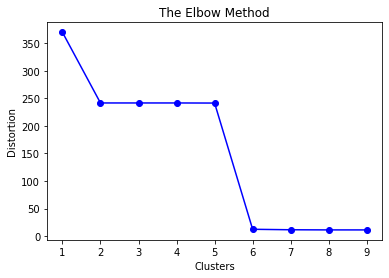

In [151]:
from scipy.spatial.distance import cdist

district_group_cluster = district_group.drop('District', 1)

distortions = []
for k in range(1,10):
    km = KMeans(n_clusters=k, random_state=3).fit(district_group_cluster)
    distortions.append(sum(np.min(cdist(district_group_cluster, km.cluster_centers_, 'canberra'), axis=1)) / district_group_cluster.shape[0])

# Plot the elbow
plt.plot(range(1,10), distortions, 'bo-')
plt.xlabel('Clusters')
plt.ylabel('Distortion')
plt.title('The Elbow Method')
plt.savefig("elbow_method.png", format='png', dpi=600, pad_inches=0)
plt.show()

#### Create a Kmeans instance and store label values in `labels`

In [152]:
# set number of clusters
kclusters = 6

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(district_group_cluster)

# check cluster labels generated for each row in the dataframe
labels = kmeans.labels_
labels[:10]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

#### Merge the original dataframe with coordinates with the most common venues

In [153]:
# add clustering labels
district_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
nj_merged = geo_df

# merge nj_merged with district_venues to add latitude/longitude for each neighborhood
nj_merged = nj_merged.join(district_venues_sorted.set_index('District'), on='District')

In [154]:
nj_merged.head(50) # check the last columns!

,District,County,Score,Percentile,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,FAIR HAVEN BORO,MONMOUTH,96.730000,99.880000,40.364270,-74.035890,1.0,New American Restaurant,Harbor / Marina,Deli / Bodega,Sandwich Place,Theme Park
1,ENGLEWOOD CLIFFS BORO,BERGEN,95.790000,99.640000,40.879240,-73.950780,1.0,Harbor / Marina,Trail,Italian Restaurant,Photography Studio,Park
2,MENDHAM TWP,MORRIS,95.575000,99.525000,40.794230,-74.568990,1.0,Baseball Field,Coffee Shop,Trail,Jewelry Store,Lake
3,UNION COUNTY VOCATIONAL,UNION,95.086000,98.510000,40.618770,-74.358700,0.0,Theater,Donut Shop,Soccer Field,Zoo Exhibit,Food Court
4,ESSEX FELLS BORO,ESSEX,93.910000,98.990000,40.830410,-74.283480,NaN,NaN,NaN,NaN,NaN,NaN
5,BERGEN COUNTY VOCATIONAL,BERGEN,93.090000,96.845000,40.959491,-74.074442,1.0,Department Store,Pizza Place,Gym / Fitness Center,Accessories Store,Hardware Store
6,MORRIS COUNTY VOCATIONAL,MORRIS,92.500000,96.275000,40.862019,-74.544274,NaN,NaN,NaN,NaN,NaN,NaN
7,OCEAN COUNTY VOCATIONAL,OCEAN,92.100000,96.275000,39.909274,-74.296965,NaN,NaN,NaN,NaN,NaN,NaN
8,MONMOUTH CO VOCATIONAL,MONMOUTH,91.808000,96.044000,40.169670,-74.063090,1.0,Intersection,Pizza Place,Bank,Ice Cream Shop,Optical Shop
9,ALLENDALE BORO,BERGEN,89.520000,97.630000,41.030430,-74.137230,1.0,Playground,Spa,Lake,Zoo Exhibit,Food Court


#### Lets break out district school scores into 3 categories

In [155]:
score_grades = []
score_ratings = []
for score in nj_merged['Score']:
    if score > 69:
        score_grade = 'High'
        score_rating = 3
    elif score > 39 and score < 70:
        score_grade = 'Medium'
        score_rating = 2
    else: 
        score_grade = 'Low'
        score_rating = 1
    
    score_grades.append(score_grade)
    score_ratings.append(score_rating)
    
print(score_grades[:50])
print(score_ratings[:50])

['High', 'High', 'High', 'High', 'High', 'High', 'High', 'High', 'High', 'High', 'High', 'High', 'High', 'High', 'High', 'High', 'High', 'High', 'High', 'High', 'High', 'High', 'High', 'High', 'Medium', 'Medium', 'High', 'High', 'High', 'High', 'High', 'High', 'High', 'High', 'High', 'High', 'High', 'High', 'High', 'High', 'High', 'High', 'High', 'High', 'High', 'High', 'High', 'High', 'High', 'High']
[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]


#### Add string and int categories to dataframe

In [156]:
nj_merged.insert(0, 'Score Grade', score_grades)
nj_merged.insert(0, 'Score Rating', score_ratings)

In [157]:
# move the new columns to the end
score_columns = list(nj_merged.columns[2:]) + [nj_merged.columns[1]] + [nj_merged.columns[0]]
nj_merged = nj_merged[score_columns]
nj_merged.head()

,District,County,Score,Percentile,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,Score Grade,Score Rating
0,FAIR HAVEN BORO,MONMOUTH,96.730,99.880,40.36427,-74.03589,1.0,New American Restaurant,Harbor / Marina,Deli / Bodega,Sandwich Place,Theme Park,High,3
1,ENGLEWOOD CLIFFS BORO,BERGEN,95.790,99.640,40.87924,-73.95078,1.0,Harbor / Marina,Trail,Italian Restaurant,Photography Studio,Park,High,3
2,MENDHAM TWP,MORRIS,95.575,99.525,40.79423,-74.56899,1.0,Baseball Field,Coffee Shop,Trail,Jewelry Store,Lake,High,3
3,UNION COUNTY VOCATIONAL,UNION,95.086,98.510,40.61877,-74.35870,0.0,Theater,Donut Shop,Soccer Field,Zoo Exhibit,Food Court,High,3
4,ESSEX FELLS BORO,ESSEX,93.910,98.990,40.83041,-74.28348,NaN,NaN,NaN,NaN,NaN,NaN,High,3


#### There are districts that returned NaN venues for the specified radius, I will assigned a cluster label of 9 to these districts

In [158]:
nj_merged['Cluster Labels'] = nj_merged['Cluster Labels'].fillna(9)
nj_merged['Cluster Labels'] = nj_merged['Cluster Labels'].astype(int)
nj_merged

,District,County,Score,Percentile,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,Score Grade,Score Rating
0,FAIR HAVEN BORO,MONMOUTH,96.730000,99.880000,40.364270,-74.035890,1,New American Restaurant,Harbor / Marina,Deli / Bodega,Sandwich Place,Theme Park,High,3
1,ENGLEWOOD CLIFFS BORO,BERGEN,95.790000,99.640000,40.879240,-73.950780,1,Harbor / Marina,Trail,Italian Restaurant,Photography Studio,Park,High,3
2,MENDHAM TWP,MORRIS,95.575000,99.525000,40.794230,-74.568990,1,Baseball Field,Coffee Shop,Trail,Jewelry Store,Lake,High,3
3,UNION COUNTY VOCATIONAL,UNION,95.086000,98.510000,40.618770,-74.358700,0,Theater,Donut Shop,Soccer Field,Zoo Exhibit,Food Court,High,3
4,ESSEX FELLS BORO,ESSEX,93.910000,98.990000,40.830410,-74.283480,9,NaN,NaN,NaN,NaN,NaN,High,3
5,BERGEN COUNTY VOCATIONAL,BERGEN,93.090000,96.845000,40.959491,-74.074442,1,Department Store,Pizza Place,Gym / Fitness Center,Accessories Store,Hardware Store,High,3
6,MORRIS COUNTY VOCATIONAL,MORRIS,92.500000,96.275000,40.862019,-74.544274,9,NaN,NaN,NaN,NaN,NaN,High,3
7,OCEAN COUNTY VOCATIONAL,OCEAN,92.100000,96.275000,39.909274,-74.296965,9,NaN,NaN,NaN,NaN,NaN,High,3
8,MONMOUTH CO VOCATIONAL,MONMOUTH,91.808000,96.044000,40.169670,-74.063090,1,Intersection,Pizza Place,Bank,Ice Cream Shop,Optical Shop,High,3
9,ALLENDALE BORO,BERGEN,89.520000,97.630000,41.030430,-74.137230,1,Playground,Spa,Lake,Zoo Exhibit,Food Court,High,3


#### Lets take a quick look at how the dataframe looks on a folium map

In [159]:
# create map
map_clusters = folium.Map(location=[40.0583, -74.4057], zoom_start=8)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.Blues(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster, score, rating in zip(nj_merged['Latitude'], nj_merged['Longitude'], nj_merged['District'], nj_merged['Cluster Labels'], nj_merged['Score'], nj_merged['Score Rating']):
    label = folium.Popup(str(poi) + '<br>' + 'Score ' + str(int(score)) + '<br>' + ' Cluster ' + str(cluster), max_width =500, parse_html=False)
    folium.CircleMarker(
        [lat, lon],
        radius=rating*5,
        popup=label,
        color='black',
        weight=0.8,
        fill=True,
        fill_color=rainbow[rating],
        fill_opacity=0.7
    )\
    .add_to(map_clusters)
       
map_clusters

#### Lets see the distribution of scores by creating 10 bins  
There seems to be a fairly even distribution of scores from low to high

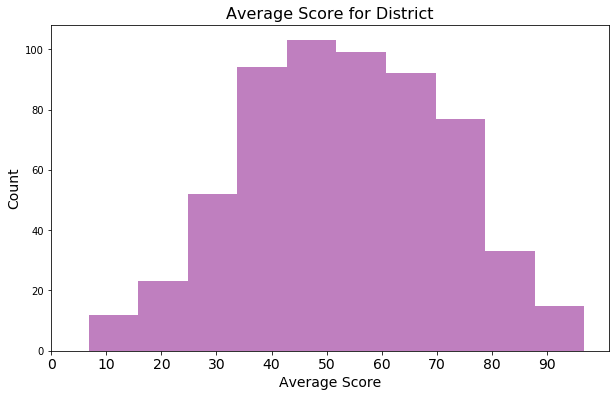

In [160]:
bins = 10
plt.figure(figsize=(10,6))
# xmin = int(nj_merged['Score'].min())
# xmax = int(nj_merged['Score'].max())
n, bins, patches = plt.hist(nj_merged['Score'], bins, facecolor='purple', alpha=0.5)
plt.title("Average Score for District",fontsize= 16)
plt.xticks(np.arange(0,100,10),fontsize=14)
plt.xlabel('Average Score', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.savefig("avg_score_hist.png", format='png', dpi=600, pad_inches=0)
plt.show()

#### Lets do some county level analysis

In [161]:
# calculate average county school scores
county_grp = school_df.groupby(['County']).mean().sort_values(by=['Score'],ascending=False).reset_index()
county_grp.head(20)

,County,Score,Percentile
0,MORRIS,66.506562,71.873125
1,BERGEN,64.979351,69.272944
2,SOMERSET,58.927639,61.591667
3,HUNTERDON,58.434500,61.649250
4,MONMOUTH,54.921351,56.048311
5,UNION,53.451181,53.330486
6,MIDDLESEX,50.829872,50.365769
7,WARREN,50.620303,50.422424
8,SUSSEX,48.162162,46.302162
9,MERCER,47.011842,45.803947


In [162]:
# convert string values to title case
county_grp['County'] = county_grp['County'].str.title()

In [163]:
county_grp.head()

,County,Score,Percentile
0,Morris,66.506562,71.873125
1,Bergen,64.979351,69.272944
2,Somerset,58.927639,61.591667
3,Hunterdon,58.434500,61.649250
4,Monmouth,54.921351,56.048311


#### To provide the county density we will provide a count of the schools belonging to each county

In [164]:
school_ct = school_df.groupby(['County']).count().reset_index()
school_ct = school_ct[['County', 'District']]
school_ct.rename(columns={'District':'County School Ct'}, inplace=True)
school_ct['County'] = school_ct['County'].str.title()
school_ct.head()

,County,County School Ct
0,Atlantic,59
1,Bergen,231
2,Burlington,100
3,Camden,129
4,Cape May,22


#### Add the count to the dataframe

In [165]:
county_coordinates_df['County'] = county_coordinates_df['County'].str.title()
final_df = county_grp.merge(county_coordinates_df, on= 'County')
final_df = final_df.merge(school_ct, on='County')
final_df.head()

,County,Score,Percentile,Latitude,Longitude,County School Ct
0,Morris,66.506562,71.873125,39.993720,-75.033770,128
1,Bergen,64.979351,69.272944,40.729310,-74.066050,231
2,Somerset,58.927639,61.591667,40.498590,-74.522490,72
3,Hunterdon,58.434500,61.649250,40.567253,-74.912179,40
4,Monmouth,54.921351,56.048311,40.260041,-74.221946,148


In [166]:
school_ct['County'] = school_ct['County'].str.upper()
final_df2 = nj_merged.merge(school_ct, on='County')
final_df2.head()

,District,County,Score,Percentile,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,Score Grade,Score Rating,County School Ct
0,FAIR HAVEN BORO,MONMOUTH,96.730,99.880,40.36427,-74.03589,1,New American Restaurant,Harbor / Marina,Deli / Bodega,Sandwich Place,Theme Park,High,3,148
1,MONMOUTH CO VOCATIONAL,MONMOUTH,91.808,96.044,40.16967,-74.06309,1,Intersection,Pizza Place,Bank,Ice Cream Shop,Optical Shop,High,3,148
2,RUMSON BORO,MONMOUTH,88.050,96.740,40.37679,-74.00487,1,Bar,Harbor / Marina,Wine Shop,Ice Cream Shop,Food Court,High,3,148
3,BRIELLE BORO,MONMOUTH,86.380,95.850,40.11241,-74.05704,1,Liquor Store,Beer Bar,Italian Restaurant,Salon / Barbershop,Breakfast Spot,High,3,148
4,LITTLE SILVER BORO,MONMOUTH,85.350,93.480,40.34006,-74.04311,1,Breakfast Spot,Pharmacy,Italian Restaurant,Spa,Chinese Restaurant,High,3,148


#### Lets analyze the first most common venue

In [167]:
common_venue = final_df2
common_venue = final_df2[['Score Grade', '1st Most Common Venue']]
common_venue.head()

,Score Grade,1st Most Common Venue
0,High,New American Restaurant
1,High,Intersection
2,High,Bar
3,High,Liquor Store
4,High,Breakfast Spot


In [168]:
common_venue.groupby('Score Grade').size()

Score Grade
High      131
Low       139
Medium    330
dtype: int64

#### Most common venues in the High category

In [169]:
clust_3 = common_venue.loc[(common_venue['Score Grade'] == 'High')]
clust_3 = clust_3['1st Most Common Venue'].value_counts()
clust_3 = pd.DataFrame(clust_3)
clust_3.rename(columns={'1st Most Common Venue':'Count'}, inplace = True)
clust_3.reset_index(drop=False, inplace=True)
clust_3.rename(columns={'index':'Venue'}, inplace = True)
clust_3.head()

,Venue,Count
0,Pizza Place,8
1,Baseball Field,7
2,Construction & Landscaping,7
3,Park,6
4,Liquor Store,6


#### Most common venues in the Medium category

In [170]:
clust_2 = common_venue.loc[(common_venue['Score Grade'] == 'Medium')]
clust_2 = clust_2['1st Most Common Venue'].value_counts()
clust_2 = pd.DataFrame(clust_2)
clust_2.rename(columns={'1st Most Common Venue':'Count'}, inplace = True)
clust_2.reset_index(drop=False, inplace=True)
clust_2.rename(columns={'index':'Venue'}, inplace = True)
clust_2.head()

,Venue,Count
0,Pizza Place,34
1,Italian Restaurant,17
2,Pet Store,17
3,Pharmacy,12
4,Chinese Restaurant,11


#### Most common venues in the Low category

In [171]:
clust_1 = common_venue.loc[(common_venue['Score Grade'] == 'Low')]
clust_1 = clust_1['1st Most Common Venue'].value_counts()
clust_1 = pd.DataFrame(clust_1)
clust_1.rename(columns={'1st Most Common Venue':'Count'}, inplace = True)
clust_1.reset_index(drop=False, inplace=True)
clust_1.rename(columns={'index':'Venue'}, inplace = True)
clust_1.head()

,Venue,Count
0,Pizza Place,12
1,Bar,11
2,Pharmacy,8
3,Baseball Field,7
4,Park,6


# 4. Results

<!-- Discuss the results -->

### 4a. Top 20 Most Frequent Venues
The results of the analysis were interesting.  When looking into the top 20 most frequent venues in the three different score categories, it was clear to see that Pizza Places were the most frequent venues across all three categories.  This could be an issue that could skew results in the analysis.  For the sake of time, I decided to ignore pizza places and start at the second most frequent venue to derive insights.    

* **High**   
    * The school districts with the highest scores seem to be near parks, liquor stores (assuming wine & spirits),and antique shops.  There are also baseball fields, banks, and coffee shops near by.  This could mean the schools have access recreational sports which could have a significant impact on the students in these schools.  
* **Medium**   
    * The school districts with the medium scores seem to be near restaurants and retail space.  This could mean that the students are living in a bit more denser locations.  Denser locations could lead to overcrowded schools and in turn less attention given to individual students.  
* **Low**   
    * The school districts with the low scores seem to be near pharmacies, liquor stores, and bars.  A large volume of pharmacies could mean that the schools are located in areas that are a bit more spread out.  It is possible these districts a located in more rural or even lower income areas.  These areas tend to pay less property taxes and therefore have less funds to offer advanced education programs in their schools.  

### 4b. County Density Map
I wanted to see if density had any impact on school score so I grouped the data by county and returned the count of schools within each county.  The result was displayed over a Leaflet map using folium to show the density of schools for each county.  We could see that Bergen and Morris counties were the most dense in terms of schools that belonged to each county.  Also, the results showed that the denser counties were more prevalent in the northern part of the state, closer to New York City.  

### 4b. Density and Score Map 
With an initial map created that displays the density of each county, I needed to see whether density had any relationship to the actual school scores for each district.  The results show that the highest scoring districts, Fair Haven, Englewood Cliffs, and Mendham are located in the northern part of the state and belong to the denser counties in the state.  We can also see from the map that the districts with the higher scores are located in the denser counties and also closer to the city.  This could mean higher property taxes, higher incomes, and access to higher education programs.  We can also see from the map that the districts with the lowest scores are primarily in areas that are away from major city centers.  An example of these districts would be Commercial, Downe, and Dennis townships which are all located in Cumberland County the least dense county in the analysis.  


#### Create a seaborn bar chart displaying all three categories and their 20 most frequent venues

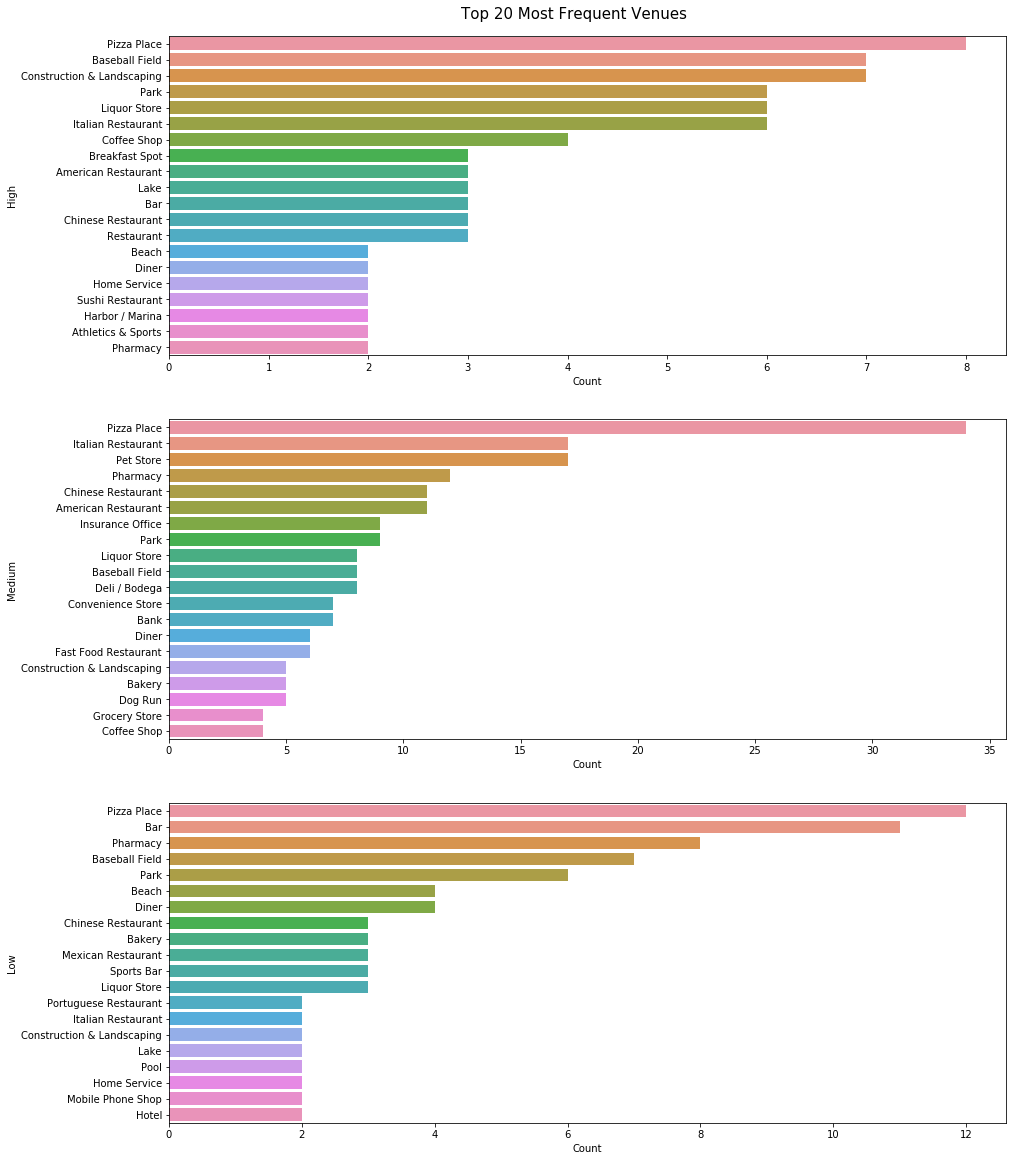

In [172]:
%matplotlib inline

fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, figsize=(15,20))
fig.suptitle("Top 20 Most Frequent Venues", y= 0.9, fontsize=15)

ax1 = sns.barplot(x='Count', y='Venue', data=clust_3[:20], ax=ax1)
ax1.set_ylabel('High')

ax2 = sns.barplot(x='Count', y='Venue', data=clust_2[:20], ax=ax2)
ax2.set_ylabel('Medium')

ax3 = sns.barplot(x='Count', y='Venue', data=clust_1[:20], ax=ax3)
ax3.set_ylabel('Low')

plt.savefig("top20_venues_hbar.png", format='png', dpi=800, pad_inches=0)
plt.show()

#### Map the county density of schools

In [173]:
url = 'https://raw.githubusercontent.com/deldersveld/topojson/master/countries/us-states/NJ-34-new-jersey-counties.json'
geo_path = json.loads(requests.get(url).text)
m = folium.Map(
    location=[40.0583, -74.4057],
    zoom_start=8  # Limited levels of zoom for free Mapbox tiles.
)

c = folium.Choropleth(geo_data=geo_path, data=county_grp, columns= ['County', 'Score'], 
                  key_on='feature.properties.NAME', 
                  fill_color = 'Reds', 
                  topojson='objects.cb_2015_new_jersey_county_20m',
                  name='County',
                  highlight=True).add_to(m)
topotip = folium.GeoJsonTooltip(fields=['NAME'], aliases=['County'], labels=False, sticky=False)
style_function = lambda x: {'fillColor': 'transparent', 'color':'transparent'}
topo = folium.TopoJson(json.loads(requests.get(url).text), 
                       'objects.cb_2015_new_jersey_county_20m', 
                       tooltip=topotip, 
                       control=False, 
                       style_function = style_function).add_to(c)
m

#### Lets put it all togther, a map that displays the districts over county density as well as tooltips

In [174]:
# set color scheme for the clusters
x = np.arange(0,10,1)
ys = [i + x + (i*x)**2 for i in range(100)]
colors_array = cm.YlOrRd(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

url = 'https://raw.githubusercontent.com/deldersveld/topojson/master/countries/us-states/NJ-34-new-jersey-counties.json'
geo_path = json.loads(requests.get(url).text)
m = folium.Map(
    location=[40.0583, -74.4057],
    zoom_start=8  # Limited levels of zoom for free Mapbox tiles.
)

fg = folium.FeatureGroup(name="District")

c = folium.Choropleth(geo_data=geo_path, data=final_df, columns= ['County', 'County School Ct'], 
             key_on='feature.properties.NAME', 
             bins=6, 
             fill_color = 'Reds', 
             topojson='objects.cb_2015_new_jersey_county_20m', 
             highlight=True,
             name='County').add_to(m)

topotip = folium.GeoJsonTooltip(fields=['NAME'], aliases=['County'], labels=False, sticky=False)

style_function = lambda x: {'fillColor': 'transparent', 'color':'transparent'}
topo = folium.TopoJson(json.loads(requests.get(url).text), 
                       'objects.cb_2015_new_jersey_county_20m', 
                       tooltip=topotip, 
                       control=False, 
                       style_function = style_function).add_to(c)

for lat, lon, poi, county, cluster, score, count, fst_venue, sc_venue, th_venue  in zip(
    final_df2['Latitude'], 
    final_df2['Longitude'], 
    final_df2['District'], 
    final_df2['County'], 
    final_df2['Cluster Labels'], 
    final_df2['Score'], 
    final_df2['County School Ct'], 
    final_df2['1st Most Common Venue'], 
    final_df2['2nd Most Common Venue'], 
    final_df2['3rd Most Common Venue']):
    
    label = folium.Popup('<h5>' + str(poi) + 
                         '<br>'+ 
                         str(county)+ ' COUNTY' + 
                         '<br>' + 
                         'Score: ' + str(int(score)) + 
                         '<br>' + 
                         ' Cluster: ' + str(cluster) + 
                         '<br>' + 
                         ' Top 3 Venues: {}, {}, {}'.format(fst_venue, sc_venue, th_venue) + 
                         '</h5', 
                         parse_html=False, 
                         max_width=500)
    
    fg.add_child(folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color='black',
        weight=0.8,
        fill=True,
        fill_color=rainbow[int(score)],
        fill_opacity=score/100,
    ))
    
m.add_child(fg)
m.add_child(folium.LayerControl())
m

# 5. Discussion

<!-- Discuss any observations you noted and any recommendations you can make based on the results -->
### 5a. Observations  
There were a few observations that I made during the analysis that should be noted.  
  1. **School scores are district averages** - For the sake of time and data size, the school scores were limited to district averages.  This means that there could have been high scoring schools in majority low score districts that were not captured as top performers.
  2. **Vocational Schools** - The data includes vocational schools which are a specific type of school that includes adult students as well.  These schools tend to have higher scores.
  3. **Charter Schools** - Charter schools are publicly funded schools that usually not associated with a school district. They are mainly found in lower income areas and have certain goals to meet to recieve their charter. These schools were removed from the analysis due to their lack of association with any specific school district.
  4. **Coordinate Data Extraction** - Since we were analyzing each school district average score, the coordinates data was extracted using the district as the location.  This dataset could be improved by using each school as a location to pull venues.
  
### 5b. Recommendations  
There are a few recommendations I would make to improve the analysis.  First, I would expand the dataset performing operations on each individual school.  Second, I would remove vocational schools from the analysis since they might skew the results for a given district.  Third, I would like to extract coordinates from each individual school and perform statistical testing on this dataset.  I believe the results would be slightly different and a bit more accurate.

# 6. Conclusion

<!-- Conclude -->
In conclusion, keeping the observations and future improvements of the analysis in mind, I believe that for people looking to either buy or rent property in New Jersey with intent to raise a family in a town with good schools should explore cities or towns in the central and northern parts of the state.  A few counties I would recommened are Morris and Bergen they have the highest average school scores and have a large volume of schools in the area for parents to choose.  I would recommend avoiding Cumberland County as it has one of the lowest average scores in the state.  

# Footnotes

[1]: [U.S. Census Bureau - New Jersey](https://www.census.gov/quickfacts/fact/table/NJ/PST045218)  
[2]: [NJ.com](https://www.nj.com/education/2019/03/nj-just-graded-its-public-schools-from-0-100-heres-how-every-school-scored.html)  
[3]: [ArcGIS](https://www.arcgis.com/index.html)  
[4]: [Foursquare](https://foursquare.com/)